In [1]:
import numpy as np
from numba import jit
import matplotlib.pyplot as plt
from itertools import product
from tqdm import tqdm
from ipdb import set_trace as bp
from numba.typed import List

from collections import namedtuple
import torch

np.set_printoptions(linewidth=160, precision=2)

In [2]:
ParamTuple = namedtuple("ParamTuple", ["gamma", "p"])

In [3]:
# @jit(nopython=True)
def value_iteration_with_policy(
    R: np.ndarray,
    T_agent: np.ndarray,
    gamma: float,
    tol: float = 1e-6,
):
    n_states = R.shape[0]
    V = np.zeros(n_states)
    policy = np.zeros(n_states, dtype=np.int32)
    while True:
        V_new = np.zeros(n_states)
        for s in range(n_states):
            action_values = R[s] + gamma * np.sum(T_agent[s] * V, axis=1)
            best_action = np.argmax(action_values)
            V_new[s] = action_values[best_action]
            policy[s] = best_action
        if np.max(np.abs(V - V_new)) < tol:
            break
        V = V_new
    V = V / np.max(V) * R.max()
    return V, policy

In [98]:
def soft_q_iteration(
    R: np.ndarray,  # R is a one-dimensional array with shape (n_states,)
    T_agent: np.ndarray,
    gamma: float,
    beta: float,  # Inverse temperature parameter for the softmax function
    tol: float = 1e-6,
):
    n_states, n_actions, _ = T_agent.shape
    V = np.zeros(n_states)
    Q = np.zeros((n_states, n_actions))
    policy = np.zeros((n_states, n_actions))

    while True:
        for s in range(n_states):
            for a in range(n_actions):
                # Calculate the Q-value for action a in state s
                Q[s, a] = R[s] + gamma * np.dot(T_agent[s, a], V)

        # Apply softmax to get a probabilistic policy
        max_Q = np.max(Q, axis=1, keepdims=True)
        exp_Q = np.exp(beta * (Q - max_Q))  # Subtract max_Q for numerical stability
        policy = exp_Q / np.sum(exp_Q, axis=1, keepdims=True)

        # Calculate the value function V using the probabilistic policy
        V_new = np.sum(policy * Q, axis=1)

        # Check for convergence
        if np.max(np.abs(V - V_new)) < tol:
            break

        V = V_new

    return V, policy

In [66]:
# def generate_trajectory(T_true, policy, absorbing_states, start_state=0, max_steps=100):
#     trajectory = []
#     current_state = start_state
#     n_states = len(policy)

#     while len(trajectory) < max_steps:
#         if current_state in absorbing_states:
#             trajectory.append((current_state, -1, -1))  # Append the absorbing state
#             break
#         chosen_action = policy[current_state]
#         # Manually sample next_state based on T_true
#         cumulative_prob = 0.0
#         rand_num = np.random.rand()
#         next_state = 0
#         for s in range(n_states):
#             cumulative_prob += T_true[current_state, chosen_action, s]
#             if rand_num < cumulative_prob:
#                 next_state = s
#                 break

#         trajectory.append((current_state, chosen_action, next_state))
#         current_state = next_state

#     trajectory = np.array(trajectory)
#     return trajectory

In [67]:
def generate_trajectory(T_true, policy, absorbing_states, start_state=0, max_steps=100):
    trajectory = []
    current_state = start_state
    n_states, n_actions = policy.shape

    while len(trajectory) < max_steps:
        if current_state in absorbing_states:
            trajectory.append((current_state, -1, -1))  # Append the absorbing state
            break
        # Sample an action based on the policy probabilities for the current state
        action_probabilities = policy[current_state]
        chosen_action = np.random.choice(n_actions, p=action_probabilities)

        # Manually sample next_state based on T_true
        next_state = np.random.choice(n_states, p=T_true[current_state, chosen_action])

        trajectory.append((current_state, chosen_action, next_state))
        current_state = next_state

    return np.array(trajectory)

In [68]:
def generate_n_trajectories(
    T_true, policy, absorbing_states, n_trajectories=100, max_steps=100
):
    trajectories = list()
    for _ in range(n_trajectories):
        trajectories.append(
            generate_trajectory(T_true, policy, absorbing_states, max_steps=max_steps)
        )
    return trajectories

In [6]:
# @jit(nopython=True)
def make_absorbing(R: np.ndarray, T: np.ndarray) -> None:
    reward_indices = np.where(R > 0)[0]
    T[reward_indices, :, :] = 0
    T[reward_indices, :, reward_indices] = 1

In [7]:
@jit(nopython=True)
def transition_matrix(N, M, p):
    n_states = N * M
    n_actions = 4  # N, E, S, W

    # Initialize the transition matrix T(s, a, s')
    T = np.zeros((n_states, n_actions, n_states))

    # Helper function to convert 2D grid indices to 1D state index
    to_s = lambda i, j: i * M + j

    # Populate the transition matrix
    for i in range(N):
        for j in range(M):
            s = to_s(i, j)

            # Neighboring states
            neighbors = {
                "N": to_s(i - 1, j) if i > 0 else s,
                "E": to_s(i, j + 1) if j < M - 1 else s,
                "S": to_s(i + 1, j) if i < N - 1 else s,
                "W": to_s(i, j - 1) if j > 0 else s,
            }

            # Set transition probabilities
            for a, action in enumerate(["N", "E", "S", "W"]):
                T[s, a, neighbors[action]] = p
                for other_action in set(["N", "E", "S", "W"]) - {action}:
                    T[s, a, neighbors[other_action]] += (1 - p) / 3

    return T

In [8]:
def plot_trajectories(N, M, trajectories, reward_matrix):
    plt.figure(figsize=(M, N))

    # Plot rewards as heatmap
    plt.imshow(reward_matrix.reshape(N, M), cmap="viridis", origin="upper")

    # Plot trajectories
    for traj in trajectories:
        x_coords, y_coords = [], []
        for s, _, _ in traj:
            x, y = divmod(s, M)
            x_coords.append(x)
            y_coords.append(y)

        # Plot the trajectories with a color that stands out
        plt.plot(y_coords, x_coords, marker="o", color="white", alpha=0.5)

    plt.colorbar(label="Reward")
    plt.gca().xaxis.tick_top()
    plt.show()

In [9]:
def plot_value_and_policy(
    value_function, policy, grid_shape, absorbing_states, title="", ax=None
):
    if ax is None:
        fig, ax = plt.subplots(figsize=grid_shape[::-1])

    ax.imshow(
        value_function.reshape(grid_shape),
        cmap="viridis",
        origin="upper",
        interpolation="nearest",
    )
    # Make colorbar
    cbar = ax.figure.colorbar(ax.get_images()[0])

    for s, val in enumerate(value_function):
        if s in absorbing_states:
            continue  # Skip arrows for absorbing states

        row, col = divmod(s, grid_shape[1])
        action = policy[s]
        if action == 0:  # N
            dx, dy = 0, -0.4
        elif action == 1:  # E
            dx, dy = 0.4, 0
        elif action == 2:  # S
            dx, dy = 0, 0.4
        elif action == 3:  # W
            dx, dy = -0.4, 0
        # make arrow
        ax.arrow(col, row, dx, dy, head_width=0.1, head_length=0.1, fc="r", ec="r")

    ax.set_title(title)

In [10]:
# Make function that counts state visit frequencies from trajectories
@jit(nopython=True)
def count_state_visits(trajectories, n_states):
    state_visits = np.zeros(n_states)
    for traj in trajectories:
        for s, _, _ in traj:
            state_visits[s] += 1
    return state_visits / state_visits.sum()

### Define a world where different $\gamma$ leads to different optimal policies


In [11]:
# World definition

# Key: S: start, Number: Reward size

# Idea: Make a reaaaaaaaaally simple BigSmall world to see if the
# likelihood calculation we have give reasonable numbers

#   0 1 2
# 0 S . .
# 1 . . .
# 2 1 . 4

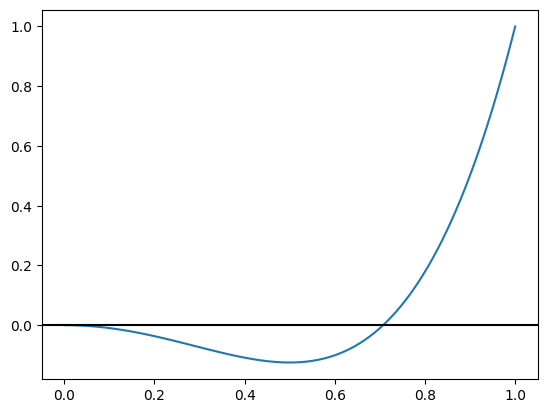

In [171]:
short_len = 2
long_len = 4
small_reward = 1

# Set big_reward such that the crossover for \gamma is at 0.75 (p = 1 for now)
big_reward = 2

xs = np.linspace(0, 1, 100)

plt.plot(xs, big_reward * xs**long_len - small_reward * xs**short_len)
plt.axhline(0, color="k")

In [72]:
N, M = 3, 3  # dimensions of the gridworld

n_states, n_actions = N * M, 4
R = np.array(
    [
        [0] * M,
        [0] * M,
        [small_reward, 0, big_reward],
    ]
).flatten()

true_params = ParamTuple(gamma=0.5, p=0.9)

T_agent_ground = transition_matrix(N, M, p=true_params.p)  # Agent's transition matrix
T_true = transition_matrix(N, M, p=0.9)  # True transition matrix
absorbing_states = np.where(R > 0)[0]  # Absorbing states

make_absorbing(R, T_agent_ground)
make_absorbing(R, T_true)

In [73]:
# Generate V and policy
V_ground, ground_policy = value_iteration_with_policy(
    R, T_agent_ground, gamma=true_params.gamma
)
non_absorbing_states = np.where(R <= 0)[0]
ground_policy[non_absorbing_states]

array([2, 2, 2, 2, 2, 2, 1], dtype=int32)

In [172]:
def det_to_prob_pol(policy, smoothing=0.0):
    policy = np.eye(n_actions)[policy]
    policy += smoothing
    policy /= policy.sum(axis=1, keepdims=True)
    return policy

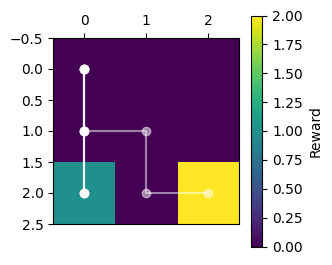

In [173]:
# Generate trajectories
trajectories = generate_n_trajectories(
    T_true,
    det_to_prob_pol(ground_policy),
    absorbing_states,
    n_trajectories=5,
    max_steps=100,
)

plot_trajectories(N, M, trajectories, R)

In [78]:
len(trajectories)

5

## Make the simplest possible case

We have two parameter samples from the posterior: $\{\gamma_1=0.5, \gamma_2 = 0.9\}$.

The first will produce a trajectory going down, the second will produce a trajectory going right.

Then, we can get the likelihood for each of these trajectories under their own $\gamma$.

Then, we can find one policy that tries to maximize the likelihood of the dataset $\mathcal D$ consisting of these two trajectories.

Hopefully (_dear god_) this will be smaller than the likelihood of the dataset $\mathcal D$ under the true $\gamma$-s.


In [174]:
posterior1 = 0.5
posterior2 = 0.9

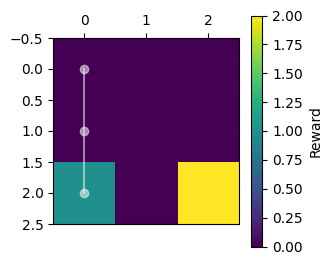

In [175]:
# Make trajectory for posterior1
_, policy1 = value_iteration_with_policy(R, T_agent_ground, gamma=posterior1)
policy1 = det_to_prob_pol(policy1, smoothing=0.0)

# Generate trajectories
trajectories1 = generate_n_trajectories(
    T_true, policy1, absorbing_states, n_trajectories=1, max_steps=100
)

plot_trajectories(N, M, trajectories1, R)

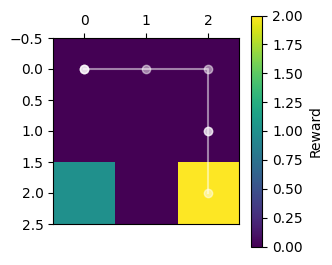

In [176]:
# Make trajectory for posterior2
_, policy2 = value_iteration_with_policy(R, T_agent_ground, gamma=posterior2)
policy2 = det_to_prob_pol(policy2, smoothing=0.0)

# Generate trajectories
trajectories2 = generate_n_trajectories(
    T_true, policy2, absorbing_states, n_trajectories=1, max_steps=100
)

plot_trajectories(N, M, trajectories2, R)

[[5.84e-06 8.14e-01 1.86e-01 5.84e-06]
 [7.85e-07 5.59e-01 4.41e-01 5.63e-12]
 [1.70e-07 1.70e-07 1.00e+00 2.38e-13]
 [1.28e-11 1.00e+00 7.83e-20 4.08e-07]
 [1.90e-13 7.97e-01 2.03e-01 4.34e-14]
 [2.16e-15 1.27e-08 1.00e+00 1.70e-15]
 [2.50e-01 2.50e-01 2.50e-01 2.50e-01]
 [1.70e-15 1.00e+00 3.24e-09 1.33e-34]
 [2.50e-01 2.50e-01 2.50e-01 2.50e-01]]


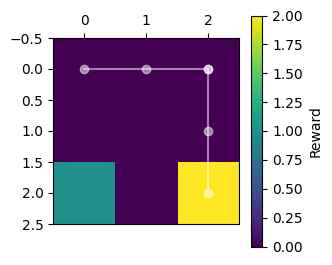

In [153]:
# Make a trajectory with soft Q-iteration
_, soft_policy = soft_q_iteration(R, T_agent_ground, gamma=posterior2, beta=10.0)
print(soft_policy)

# Generate trajectories
soft_trajectories = generate_n_trajectories(
    T_true, soft_policy, absorbing_states, n_trajectories=1, max_steps=100
)

plot_trajectories(N, M, soft_trajectories, R)

<BarContainer object of 4 artists>

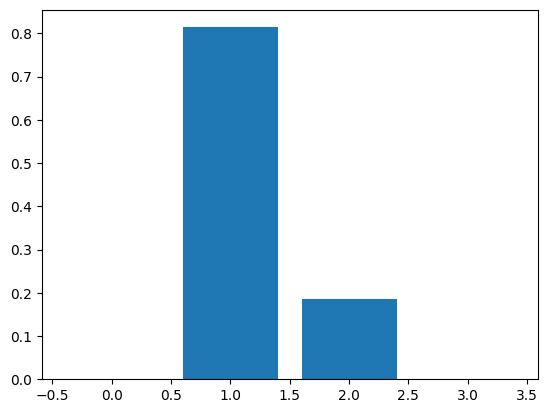

In [154]:
# Plot distribution of Q-values for state 0
plt.bar(np.arange(soft_policy[0].shape[0]), soft_policy[0])

In [21]:
policies = [policy1, policy2]

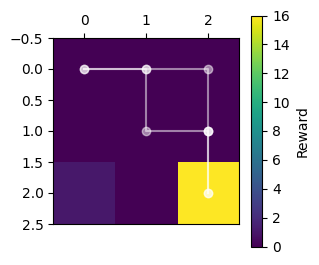

In [22]:
trajectories = trajectories1 + trajectories2

plot_trajectories(N, M, trajectories, R)

In [23]:
# Make function to calculate log-likelihood of a trajectory given a transition matrix and policy
def log_likelihood(T, policy, trajectory):
    log_likelihood = 0.0
    for s, a, next_s in trajectory[:-1]:
        log_likelihood += np.log(T[s, a, next_s] * policy[s, a])
    return log_likelihood


def log_likelihood_torch(T, policy, trajectory):
    log_likelihood = torch.tensor(0.0)
    for s, a, next_s in trajectory[:-1]:
        log_likelihood += torch.log(T[s, a, next_s] * policy[s, a])
    return log_likelihood

In [24]:
cand_pol = np.ones((n_states, n_actions)) / n_actions

In [25]:
(
    log_likelihood(T_true, policies[0], trajectories[0]),
    log_likelihood(T_true, cand_pol, trajectories[0]),
    log_likelihood(T_true, policies[1], trajectories[1]),
    log_likelihood(T_true, cand_pol, trajectories[1]),
)

(-3.822639444293461,
 -10.754111249892913,
 -0.4214420626313051,
 -5.966619507110868)

In [26]:
(
    (
        log_likelihood(T_true, policies[0], trajectories[0])
        + log_likelihood(T_true, policies[1], trajectories[1])
    )
    / 2,
    (
        log_likelihood(T_true, cand_pol, trajectories[0])
        + log_likelihood(T_true, cand_pol, trajectories[1])
    )
    / 2,
)

(-2.122040753462383, -8.360365378501891)

In [27]:
from tqdm import trange

best = -np.inf
best_pol = None
best_list = []

100%|██████████| 5000000/5000000 [01:30<00:00, 55419.14it/s]


(-3.944110670654826,
 array([[0.05, 0.89, 0.02, 0.04],
        [0.01, 0.36, 0.61, 0.03],
        [0.02, 0.01, 0.68, 0.29],
        [0.4 , 0.42, 0.01, 0.17],
        [0.21, 0.56, 0.21, 0.02],
        [0.19, 0.01, 0.74, 0.06],
        [0.41, 0.19, 0.32, 0.08],
        [0.19, 0.65, 0.11, 0.05],
        [0.24, 0.06, 0.01, 0.69]]))

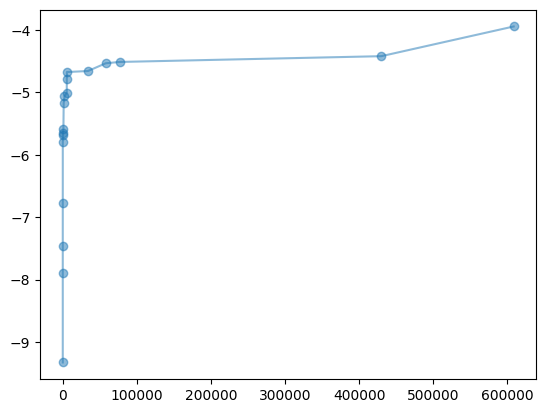

In [28]:
for i in trange(5_000_000):
    # Sample a new policy
    cand_pol = np.random.dirichlet(np.ones(n_actions), size=n_states)

    mean_log_likelihood = np.array(
        [log_likelihood(T_true, cand_pol, traj) for traj in trajectories]
    ).mean()

    if mean_log_likelihood > best:
        best = mean_log_likelihood
        best_pol = cand_pol
        best_list.append((i, best))

# Plot the best list with circles
plt.plot([x[0] for x in best_list], [x[1] for x in best_list], "-o", alpha=0.5)

best, best_pol

## Put it all together to a more comprehensive example


In [29]:
def random_policy_maximization(n_states, n_actions, trajectories, T_true):
    best_likelihood = -np.inf
    best_pol = None
    best_list = []
    for i in trange(1_000_000):
        # Sample a new policy
        cand_pol = np.random.dirichlet(np.ones(n_actions), size=n_states)

        mean_log_likelihood = np.array(
            [log_likelihood(T_true, cand_pol, traj) for traj in trajectories]
        ).mean()

        if mean_log_likelihood > best_likelihood:
            best_likelihood = mean_log_likelihood
            best_pol = cand_pol
            best_list.append((i, best_likelihood))

    print(f"Best policy: {best_pol}")

    # Plot the best_likelihood list with circles
    # plt.plot([x[0] for x in best_list], [x[1] for x in best_list], "-o", alpha=0.5)

    print(f"Best likelihood: {best_likelihood}")

    return best_pol, best_likelihood

In [202]:
def grad_policy_maximization(n_states, n_actions, trajectories, T_true):
    candidate_pi = torch.ones(n_states, n_actions) / n_actions
    candidate_pi.requires_grad = True
    optimizer = torch.optim.Adam([candidate_pi], lr=0.1)
    # trajectories = torch.tensor(trajectories)
    T_true = torch.tensor(T_true)

    for i in trange(1_000):
        optimizer.zero_grad()
        # candidate_pi /= candidate_pi.sum(axis=1, keepdims=True).detach()
        mean_log_likelihood = torch.stack(
            [log_likelihood_torch(T_true, candidate_pi, traj) for traj in trajectories]
        ).mean()
        (-mean_log_likelihood).backward()
        optimizer.step()

        with torch.no_grad():
            candidate_pi /= candidate_pi.sum(axis=1, keepdims=True)

    candidate_pi = candidate_pi.detach().numpy()
    candidate_pi /= candidate_pi.sum(axis=1, keepdims=True)

    mean_log_likelihood = torch.stack(
        [log_likelihood_torch(T_true, candidate_pi, traj) for traj in trajectories]
    ).mean()

    return candidate_pi, mean_log_likelihood.numpy()

In [220]:
import random


def run_likelihood_exp(small_reward=1, big_reward=4, N=3, M=3, seed=69):
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)

    n_states, n_actions = N * M, 4
    R = np.zeros((N, M))

    R[-1, 0] = small_reward
    R[-1, -1] = big_reward

    R = R.flatten()

    T_true = transition_matrix(N, M, p=0.9)  # True transition matrix
    T_agent_ground = transition_matrix(N, M, p=0.9)
    absorbing_states = np.where(R > 0)[0]  # Absorbing states
    make_absorbing(R, T_true)
    make_absorbing(R, T_agent_ground)

    posteriors = np.linspace(0.5, 0.9, 20)
    # policies = []
    all_trajectories = []
    star_likelihoods = []

    # Make trajectory for posteriors
    for posterior in posteriors:
        _, policy = soft_q_iteration(R, T_agent_ground, gamma=posterior, beta=10.0)
        # _, policy = value_iteration_with_policy(R, T_agent_ground, gamma=posterior)
        # policy = det_to_prob_pol(policy, smoothing=0.0)

        # Generate trajectories
        trajectories = generate_n_trajectories(
            T_true, policy, absorbing_states, n_trajectories=10, max_steps=100
        )

        all_trajectories += trajectories
        # Calculate likelihood of trajectories
        star_likelihoods += [
            log_likelihood(T_true, policy, traj) for traj in trajectories
        ]

    plot_trajectories(N, M, all_trajectories, R)

    max_likelihood_policy, _ = grad_policy_maximization(
        n_states,
        n_actions,
        all_trajectories,
        T_true,
    )

    # Now use the max_likelihood_policy to calculate the likelihood of each of the trajectories so we can normalize with the star likelihoods
    likelihoods = [
        log_likelihood(T_true, max_likelihood_policy, traj) for traj in all_trajectories
    ]

    likelihood_array = np.array([star_likelihoods, likelihoods]).T

    # Test with normalize likelihoods
    likelihood_array /= likelihood_array[:, :1]

    mean_likelihood_star, likelihood = likelihood_array.mean(axis=0)

    print(f"Likelihood star: {mean_likelihood_star}, likelihood: {likelihood}")

    # print(f"Best policy:\n{max_likelihood_policy}")
    return mean_likelihood_star, likelihood

Posterior: 0.5
Posterior: 0.5210526315789473
Posterior: 0.5421052631578948
Posterior: 0.5631578947368421
Posterior: 0.5842105263157895
Posterior: 0.6052631578947368
Posterior: 0.6263157894736842
Posterior: 0.6473684210526316
Posterior: 0.6684210526315789
Posterior: 0.6894736842105263
Posterior: 0.7105263157894737
Posterior: 0.7315789473684211
Posterior: 0.7526315789473684
Posterior: 0.7736842105263158
Posterior: 0.7947368421052632
Posterior: 0.8157894736842105
Posterior: 0.8368421052631578
Posterior: 0.8578947368421053
Posterior: 0.8789473684210527
Posterior: 0.9


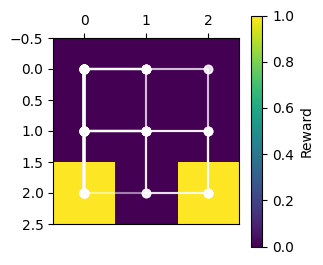

 47%|████▋     | 471/1000 [00:06<00:07, 70.12it/s]

In [221]:
results1 = (
    run_likelihood_exp(big_reward=1),
    run_likelihood_exp(big_reward=2),
    run_likelihood_exp(small_reward=0, big_reward=8),
)

In [217]:
res1 = np.array(results1)

# res1 = np.exp(res1)
# res1 /= res1[:, 0:1]
# res1 = -np.diff(res1, axis=1).flatten()

with np.printoptions(precision=5, suppress=True):
    print(res1)

[[1.      1.     ]
 [1.      1.90771]
 [1.      0.95002]]


Posterior: 0.5
Posterior: 0.9


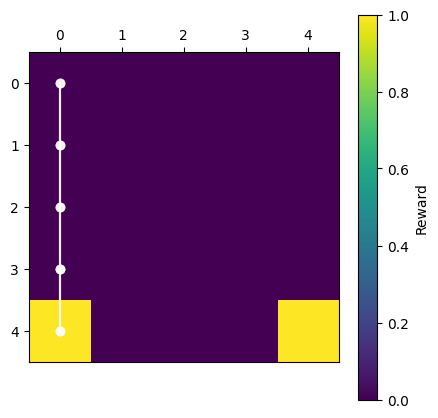

100%|██████████| 1000/1000 [00:00<00:00, 1822.93it/s]


Likelihood star: 1.0, likelihood: 0.9875407949665684
Posterior: 0.5
Posterior: 0.9


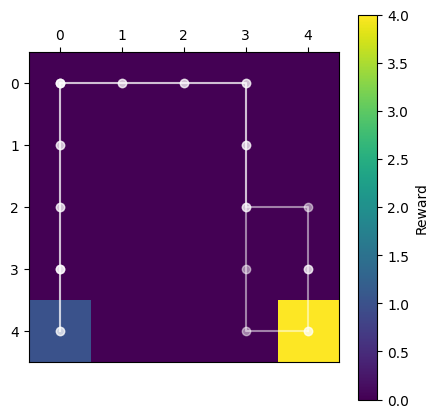

100%|██████████| 1000/1000 [00:00<00:00, 1294.61it/s]


Likelihood star: 1.0, likelihood: 1.4430863338302982
Posterior: 0.5
Posterior: 0.9


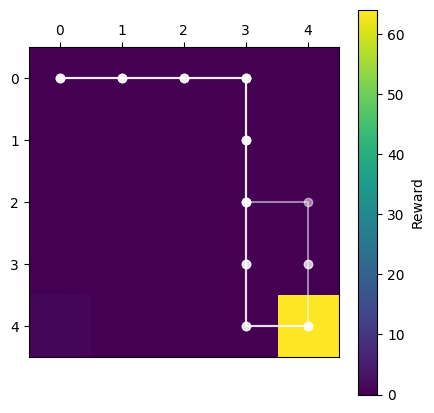

100%|██████████| 1000/1000 [00:01<00:00, 964.49it/s]

Likelihood star: 1.0, likelihood: 0.5925480778040559


In [218]:
results2 = (
    run_likelihood_exp(big_reward=1, N=5, M=5),
    run_likelihood_exp(big_reward=4, N=5, M=5),
    run_likelihood_exp(big_reward=64, N=5, M=5),
)

In [219]:
res2 = np.array(results2)

# res2 = np.exp(res2)
# res2 /= res2[:, 0:1]
# res2 = -np.diff(res2, axis=1).flatten()

with np.printoptions(precision=5, suppress=True):
    print(res2)

[[1.      0.98754]
 [1.      1.44309]
 [1.      0.59255]]
